# A basic neural net from scratch
A simple digit classifier which follows the gradient descent process
1. Initialize
2. Predict
3. Calculate loss
4. Calculate gradient
5. Step
6. Repeat
7. Stop

Only looks at two digits, 3's and 7's, to keep it simple.

In [157]:
from fastai.vision.all import *
from utils import *

## Fetch some data

In [158]:
path = untar_data(URLs.MNIST_SAMPLE)

In [159]:
Path.BASE_PATH = path

In [160]:
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [161]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [162]:
im3_path = threes[1]
im3 = Image.open(im3_path)

im3

In [163]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[0:28,0:28])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


## Prep data

In [164]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

len(three_tensors), len(seven_tensors)

(6131, 6265)

In [165]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

stacked_threes.shape

torch.Size([6131, 28, 28])

In [166]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [167]:
# reduce to 2 dimensional vectors
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [168]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [169]:
dset = list(zip(train_x,train_y))
x,y = dset[0]

x.shape,y

(torch.Size([784]), tensor([1]))

In [170]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)

valid_dset = list(zip(valid_x,valid_y))

### Define helper functions

In [171]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [172]:
def linear1(xb): return xb@weights + bias

In [173]:
def sigmoid(x): return 1/(1+torch.exp(-x))

In [174]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [175]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [176]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

### Test with a mini batch

In [177]:
weights = init_params((28*28,1))
bias = init_params(1)

In [178]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [179]:
preds = linear1(batch)
preds

tensor([[-7.0567],
        [ 3.8336],
        [-8.6935],
        [-5.6520]], grad_fn=<AddBackward0>)

In [180]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.7542, grad_fn=<MeanBackward0>)

In [181]:
calc_grad(batch, train_y[:4], linear1)

In [182]:
(preds>0.5).float() == train_y[:4]

tensor([[False],
        [ True],
        [False],
        [False]])

In [183]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.2500)


### Setup batches for training and validation sets

In [184]:
dl = DataLoader(dset, batch_size=256)

In [185]:
# dependent and independent
xb,yb = first(dl)

xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [186]:
valid_dl = DataLoader(valid_dset, batch_size=256)

## Let's do some training

In [187]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [188]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [189]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

### A linear model v0

In [190]:
def train_epoch_0(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [191]:
validate_epoch(linear1)

0.2437

In [192]:
lr = 1.
params = weights,bias

In [193]:
train_epoch_0(linear1, lr, params)

In [194]:
validate_epoch(linear1)

0.5559

In [195]:
for i in range(20):
    train_epoch_0(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.599 0.8241 0.9022 0.9295 0.9422 0.9456 0.9476 0.951 0.9554 0.9564 0.9584 0.9603 0.9628 0.9638 0.9638 0.9662 0.9677 0.9691 0.9706 0.9711 

### A linear model v1

In [196]:
# init linear to random
linear_model = nn.Linear(28*28,1)

In [197]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [198]:
opt = SGD(linear_model.parameters(), lr)

train_model(linear_model, 20)

0.4932 0.8232 0.8477 0.9136 0.9355 0.9482 0.9546 0.9629 0.9658 0.9673 0.9687 0.9717 0.9736 0.9751 0.9756 0.9766 0.9775 0.978 0.978 0.9785 

### A linear model v2

In [199]:
dls = DataLoaders(dl, valid_dl)

In [200]:
learn = Learner(dls, 
                nn.Linear(28*28,1), 
                opt_func=SGD,
                loss_func=mnist_loss, 
                metrics=batch_accuracy)

In [201]:
learn.fit(40, lr=0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.208370,0.371110,0.540726,00:00
1,0.118722,0.183635,0.873405,00:00
2,0.082379,0.107971,0.935231,00:00
3,0.064845,0.080391,0.955839,00:00
4,0.055299,0.066925,0.963690,00:00
5,0.049502,0.059021,0.963690,00:00
6,0.045614,0.053811,0.965162,00:00
7,0.042784,0.050099,0.967125,00:00
8,0.040592,0.047303,0.968106,00:00
9,0.038816,0.045110,0.970069,00:00


### A basic neural network

In [202]:
#def simple_net(xb):
#    res = xb@w1 + b1
#    res = res.max(tensor(0.0))
#    res = res@w2 + b2
#    return res

In [203]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [204]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [205]:
learn = Learner(dls, 
                simple_net, 
                opt_func=SGD,
                loss_func=mnist_loss, 
                metrics=batch_accuracy)

In [206]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.316903,0.400495,0.507360,00:00
1,0.147292,0.220435,0.816487,00:00
2,0.081095,0.110834,0.922473,00:00
3,0.053103,0.075098,0.943081,00:00
4,0.040204,0.058933,0.960255,00:00
5,0.033658,0.049853,0.965653,00:00
6,0.029916,0.044119,0.967125,00:00
7,0.027492,0.040189,0.968106,00:00
8,0.025747,0.037330,0.969578,00:00
9,0.024394,0.035147,0.971541,00:00


### Final accuracy

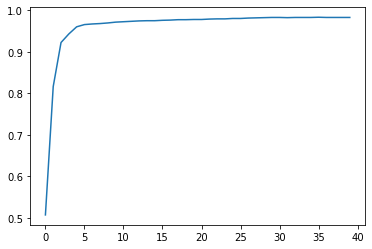

In [207]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [208]:
learn.recorder.values[-1][2]

0.982826292514801